# Deep Q-Network on LunarLander-v3

## Introduction

In this project we introduce theoretical concepts behind Deep Q-Network, a powerful reinforcement learning technique, and detail the implementation and performance of our agent in the task.

## Part 1: Theoretical Backgrounds

### Q-Learning
Value-based methods focus on estimating and using the state-value function $V(s)$ or the action-value function $Q(s,a)$ to make decision and learn optimal policies. A representative method is Q-learning introduced by [Watkins (1989)]() and further developed by [Watkins and Dayan (1992)](). Instead of trying to estimate the transition function $P_t(s'\mid s,a)$ we focus on learning the action-value function directly.

Suppose we take an action $a$ given an initial state $s$. We receive a reward $r(s,a)$ and observe a new state $s'$. Under the optimal policy, we have

$$
Q(s,a) = r(s,a) + V^*(s')
$$

where $V^*$ is the maximum state-value under the optimal policy. We can also write the above equation as

$$
Q(s,a) = r(s,a) + \max_{a'\in\mathcal A}Q(s',a').
$$

At every time step $t$, we choose an action that gives the maximum action-value, in which case the policy is called greedy with respect to $Q(s,a)$. Following the policy, we store the experiences (the states, actions, rewards, etc.). When the episode is over, we update the action-value function to some new $Q'(s,a)$:

$$
Q'(s,a) = (1-\alpha)Q(s,a) + \alpha\left( r(s,a) + \max_{a'\in\mathcal A} Q(s',a') \right).
$$

for some constant $\alpha$. 

However, if the agent always chooses the action that maximises the current estimate of the action-value function, it may lose chances to discover better actions that could have given higher rewards. There is a trade-off between exploration and exploitation.

Explotation refers to choosing the best possible actions based on what the agent has learned so far. On the other hand, exploration means trying out new actions that may lead to discover higher rewards. Without sufficient exploration, the agent might converge to a suboptimal policy, misisng out on better strategies.

One approach to balance exploration and exploitation is the $\epsilon$-greedy strategy ([Sutton and Barto (2018)]()). The agent randomly chooses any action with pre-specified probability $\epsilon$ for exploration. In this case we have

$$
a_t = 
\begin{cases} 
\arg\max_{a\in\mathcal A}Q_t(s,a) & \text{with probability } 1-\epsilon
\\ 
\text{random action from }\mathcal A & \text{with probability } \epsilon
\end{cases}
$$

### Deep Q-Network

In Q-learning, we store the values for every possible state-action pair in a table called Q-table. However, the number of states and actions grow exponentially as the number of dimensions increases, making the task of finding the optimal policy computationally challenging.

[Mnih, Kavukcuoglu, et al. (2015)]() suggested that we approximate the action-value function with a neural network, instead of iterating over states whose dimension can be very large. That is, we paremeterise the action-value function $Q(s,a)$ by some parameters $\theta$  and use $Q(s,a;\theta) instead.

As Tsitsiklis and Van Roy (1996) pointed out, using a nonlinear function approximator such as a neural network can make learning unstable or to diverge. This happens when the sequence of observations have high correlations or when the small updates in the action-value function significantly changes the policy and therefore affects the distribution of the data. To address this issue, DQN uses two ideas: expereince reply ([Lin (1992)]()) and separating the behaviour and the target network.

#### Experience Replay
We store the experience of the agent at time step $t$, $(s_t, a_t, r_t, s_{t+1})$, in the replay memory $\mathcal D$. During training, we randomly sample a mini-batch of samples $(s_i, a_i, r_i, s_i')$ of size $B$ for some pre-specified batch size $B$ from the memory to train the network. If the size of the replay memory is large enough, we can obtain uncorrelated and nearly independent samples. This reduces the variance of the gradient $\nabla_\theta L(\theta)$ and stabilises the training process.

#### Behaviour and Target Networks
We utilise two neural networks having identical structures: a behaviour network and a target network. The behaviour network, parameterised by $\theta$, calculates the action-value of the current time step and is updated by gradient descent method:

$$
\theta \leftarrow \theta-\nabla_\theta L(\theta).
$$

The target network, parameterised by $\theta'$, are periodically updated every $C$ steps, where $C$ is a hyperparameter:

$$
\theta' = (1-\tau)\theta' + \tau\theta
$$

for another hyperparameter $tau$. 

Our loss function, therefore, is

$$
L(\theta) = \frac{1}{B}\sum_{i=1}^B\left( (r_i + \max_{a'\in\mathcal A}Q(s_i', a';\theta')) - Q(s_i,a_i;\theta) \right).
$$

Note that the target network is only used to calculate $r+\max_{a'\in\mathcal A}Q(s_i', a';\theta')$.

![dqn-algorithm](../../figures/dqn.png)

## Part 2: Implementation

### Load libraries

In [1]:
import gymnasium as gym

# Initialise the environment
env = gym.make("LunarLander-v3", render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)
for _ in range(1000):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

2025-03-23 00:12:56.177 Python[93235:5102906] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-23 00:12:56.177 Python[93235:5102906] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tqdm
import random
from collections import deque, namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

### Define the policy network

In [3]:
class QNet(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden=64):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(n_states, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

### Define the replay buffer

In [4]:
class ReplayBuffer():
    def __init__(self, n_actions, memory_size, batch_size):
        self.n_actions = n_actions
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def __len__(self):
        return len(self.memory)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

### Define the DQN agent

In [5]:
class DQN():
    def __init__(self, n_states, n_actions, batch_size=64, lr=1e-4, gamma=0.99, memory_size=int(1e5), tau=1e-3, learn_step=5):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.lr = lr
        self.gamma = gamma
        self.memory_size = memory_size
        self.tau = tau
        self.learn_step = learn_step

        # model
        self.net_eval = QNet(n_states, n_actions).to(device)
        self.net_target = QNet(n_states, n_actions).to(device)
        self.optimizer = optim.Adam(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # memory
        self.memory = ReplayBuffer(n_actions, memory_size, batch_size)
        self.counter = 0 # Update cycle counter
    
    def act(self, state, epsilon):
        # print(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.net_eval.eval()
        with torch.no_grad():
            action_values = self.net_eval(state)
        self.net_eval.train()

        # epsilon-greedy policy
        if random.random() < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            action = np.argmax(action_values.cpu().data.numpy())
        
        return action
    
    def save_to_memory(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)
    
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        y_j = rewards + self.gamma * (1 - dones) * q_target
        q_eval = self.net_eval(states).gather(1, actions)

        # loss backpropagation
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update()

    def soft_update(self):
        for target_param, eval_param in zip(self.net_target.parameters(), self.net_eval.parameters()):
            target_param.data.copy_(self.tau * eval_param.data + (1.0 - self.tau) * target_param.data)

### Define train function

In [6]:
def train(env, agent, n_episodes=2000, max_steps=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995, target=200):
    score_history = []
    epislon = eps_start

    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    progress_bar = tqdm.trange(n_episodes, unit="ep", bar_format=bar_format, ascii=True)

    for i in progress_bar:
        state, _ = env.reset()

        score = 0
        for t in range(max_steps):
            action = agent.act(state, epislon)
            next_state, reward, done, _, _ = env.step(action)
            agent.save_to_memory(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        score_history.append(score)
        score_avg = np.mean(score_history[-100:])
        epislon = max(epislon * eps_decay, eps_end)

        progress_bar.set_postfix_str(f"Score: {score: 7.2f}, 100 score avg: {score_avg: 7.2f}")
        progress_bar.update(0)

        # Early stopping
        if len(score_history) > 100:
            if score_avg >= target:
                break
        
    if (i + 1) < n_episodes:
        print("\nTarget score reached!")
    else:
        print("\nDone!")

    torch.save(agent.net_eval.state_dict(), f"./dqn-trained.h5")

    return score_history

### Training

In [8]:
# Set hyperparameters
BATCH_SIZE = 128
LR = 1e-3
EPISODES = 5000
TARGET_SCORE = 250.     # early training stop at avg score of last 100 episodes
GAMMA = 0.99            # discount factor
MEMORY_SIZE = 10000     # max memory buffer size
LEARN_STEP = 5          # how often to learn
TAU = 1e-3              # for soft update of target parameters

train_env = gym.make('LunarLander-v3')
num_states = train_env.observation_space.shape[0]
num_actions = train_env.action_space.n
agent = DQN(
    n_states = num_states,
    n_actions = num_actions,
    batch_size = BATCH_SIZE,
    lr = LR,
    gamma = GAMMA,
    memory_size = MEMORY_SIZE,
    learn_step = LEARN_STEP,
    tau = TAU
)

In [9]:
score_hist = train(train_env, agent, n_episodes=EPISODES, target=TARGET_SCORE)

 73%|#######2  | 3634/5000 [  29:20<  11:01,  2.06ep/s, Score:  242.80, 100 score avg:  251.18] 


Target score reached!


In [16]:
# save the training history as csv file

df = pd.DataFrame(score_hist, columns=["score"])
df.to_csv("dqn-score-history.csv", index=False)


### Define visualisation function

In [10]:
def plotScore(scores):
    plt.figure(figsize=(10, 5))
    plt.plot(scores)
    plt.title("Score History")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.savefig("dqn-score-history.png")
    plt.show()

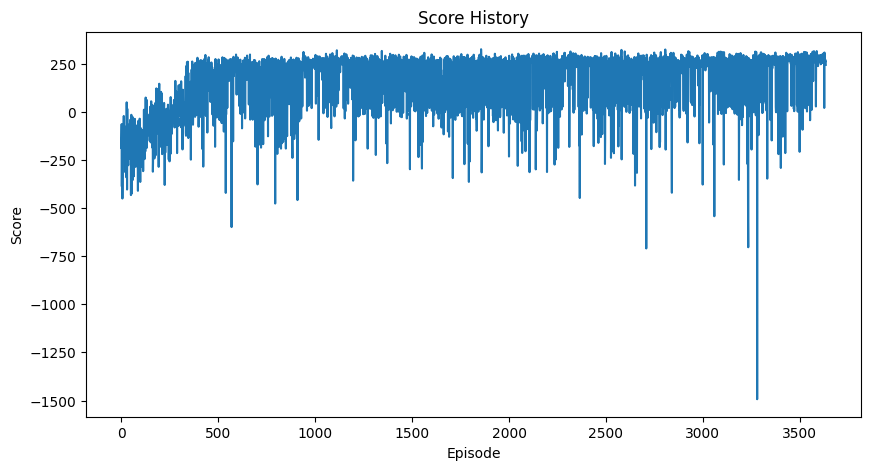

In [11]:
# Visualise training history
plotScore(score_hist)

### Define test function

In [7]:
def test(env, agent, loop=3):
    for i in range(loop):
        state, _ = env.reset()
        for t in range(500):
            action = agent.act(state, 0)
            env.render()
            state, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break
    env.close()
            

### Test

In [12]:
# Set hyperparameters
BATCH_SIZE = 128
LR = 1e-3
GAMMA = 0.99            # discount factor
MEMORY_SIZE = 10000     # max memory buffer size
LEARN_STEP = 5          # how often to learn
TAU = 1e-3              # for soft update of target parameters

In [13]:
test_env = gym.make('LunarLander-v3', render_mode="human")
num_states = test_env.observation_space.shape[0]
num_actions = test_env.action_space.n
agent = DQN(
    n_states = num_states,
    n_actions = num_actions,
    batch_size = BATCH_SIZE,
    lr = LR,
    gamma = GAMMA,
    memory_size = MEMORY_SIZE,
    learn_step = LEARN_STEP,
    tau = TAU
)

# Load the trained agent
agent.net_eval.load_state_dict(torch.load(f'./dqn-trained.h5', weights_only=True))

<All keys matched successfully>

In [14]:
test(test_env, agent, loop=10)